In [45]:
import json
import pandas as pd
from pathlib import Path
import re

# Load evaluated message_logs.json
input_path = Path("evaluated_bot_chats")
all_files = list(input_path.glob("round_*/message_logs.json"))

records = []

for file in all_files:
    round_name = file.parent.name
    with open(file, "r") as f:
        data = json.load(f)

    for participant, sessions in data.items():
        if not isinstance(sessions, dict):
            continue

        for key, value in sessions.items():
            # Match flattened score keys like session_1_score_empathy
            match = re.match(r"(session_\d+)_score_(\w+)", key)
            if match:
                session_id, score_type = match.groups()
                records.append({
                    "round": round_name,
                    "participant": participant,
                    "session": session_id,
                    "score_type": score_type,
                    "score": value
                })

# Convert to tidy DataFrame
df = pd.DataFrame(records)

# Pivot to wide format: one row per (round, participant, session)
pivot_df = df.pivot_table(
    index=["round", "participant", "session"],
    columns="score_type",
    values="score"
).reset_index()

# Rename columns for clarity
pivot_df.columns.name = None
pivot_df = pivot_df.rename(columns={
    "emotional_reactions": "emotional_reactions",
    "explorations": "explorations",
    "interpretations": "interpretations",
    "empathy": "empathy"
})

# Aggregate per participant per round
agg_df = pivot_df.groupby(["round", "participant"]).agg(
    avg_emotional_reactions=("emotional_reactions", "mean"),
    avg_explorations=("explorations", "mean"),
    avg_interpretations=("interpretations", "mean"),
    avg_empathy=("empathy", "mean"),
    session_count=("session", "count")
).reset_index()

# Show result
agg_df.head(20)


,round,participant,avg_emotional_reactions,avg_explorations,avg_interpretations,avg_empathy,session_count
0,round_1,whatsapp:+12679710379,1.0,2.00,1.0,2.00,1
1,round_1,whatsapp:+13127090097,1.0,2.00,1.0,1.00,1
2,round_1,whatsapp:+13363019854,1.0,2.00,1.0,1.00,1
3,round_1,whatsapp:+14045280621,1.0,1.75,1.0,1.25,4
4,round_1,whatsapp:+15094261432,1.0,2.00,1.0,2.00,1
5,round_1,whatsapp:+16123868977,1.0,2.00,1.0,2.00,1
6,round_1,whatsapp:+16613610080,1.0,2.00,1.0,1.00,1
7,round_1,whatsapp:+18628813389,1.0,2.00,1.0,1.00,1
8,round_1,whatsapp:+19188108927,1.0,2.00,1.0,2.00,1
9,round_1,whatsapp:+254769432017,1.0,2.00,1.0,1.00,1


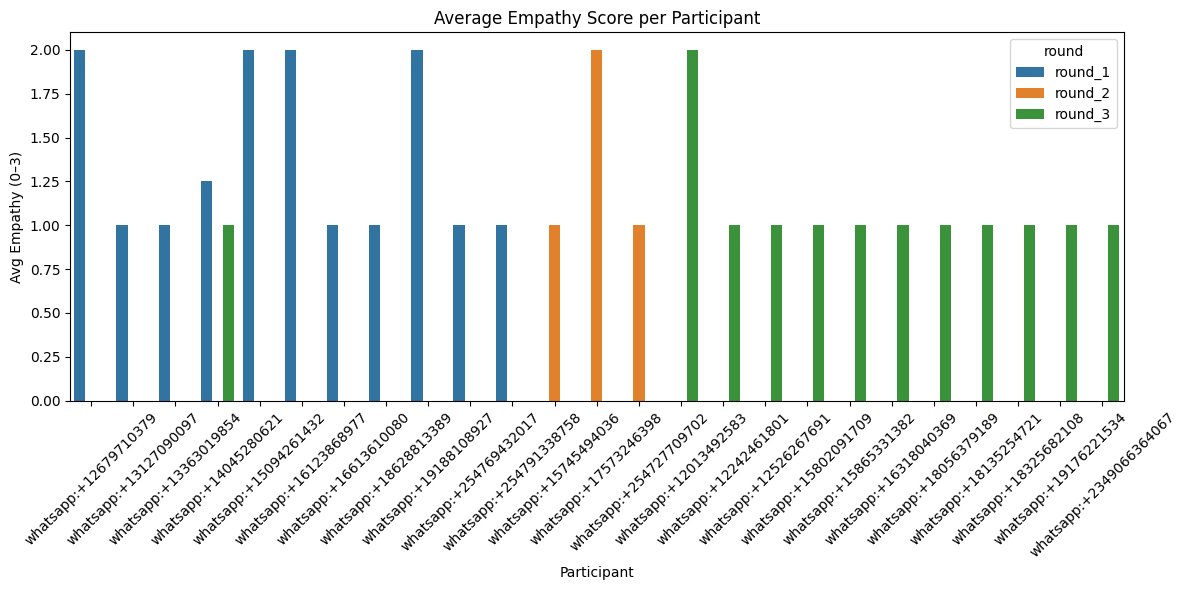

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.barplot(data=agg_df, x="participant", y="avg_empathy", hue="round")
plt.xticks(rotation=45)
plt.title("Average Empathy Score per Participant")
plt.ylabel("Avg Empathy (0–3)")
plt.xlabel("Participant")
plt.tight_layout()
plt.show()


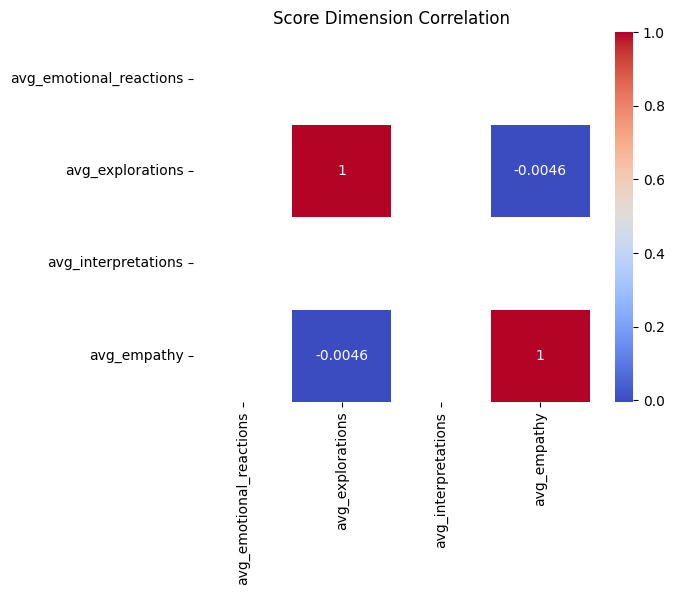

In [13]:

corr = agg_df[["avg_emotional_reactions", "avg_explorations", "avg_interpretations", "avg_empathy"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Score Dimension Correlation")
plt.show()


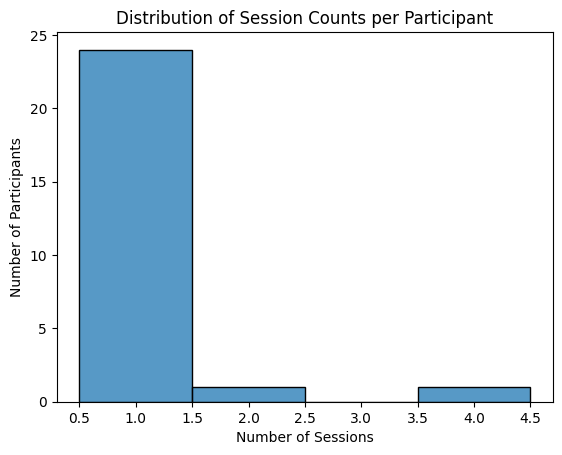

In [14]:
sns.histplot(data=agg_df, x="session_count", bins=range(1, 6), discrete=True)
plt.title("Distribution of Session Counts per Participant")
plt.xlabel("Number of Sessions")
plt.ylabel("Number of Participants")
plt.show()

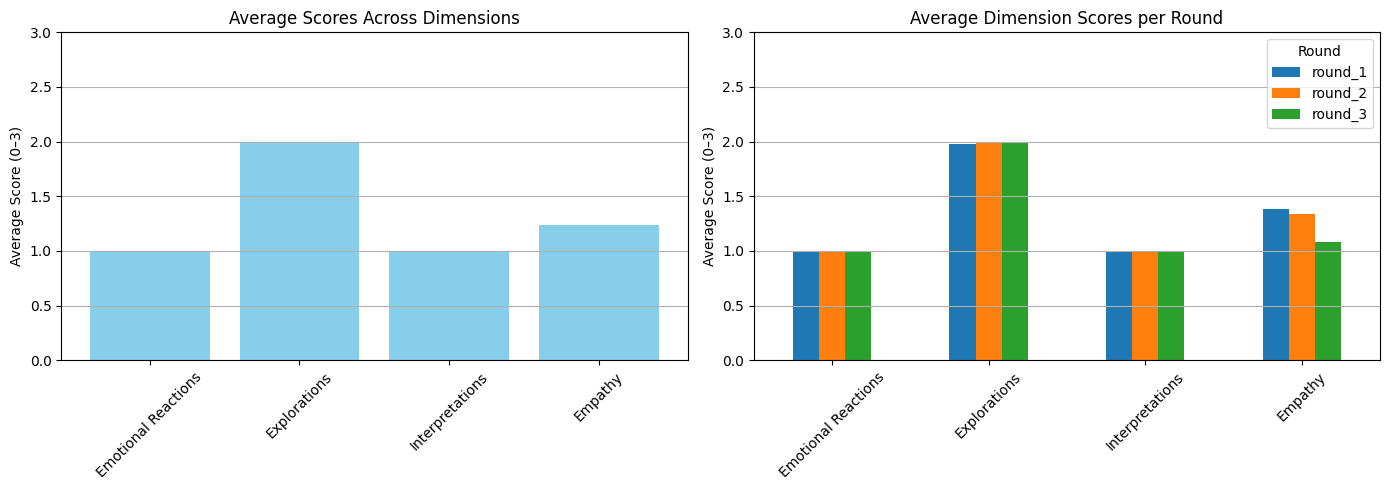

In [19]:
import matplotlib.pyplot as plt

dimensions = ["avg_emotional_reactions", "avg_explorations", "avg_interpretations", "avg_empathy"]
dimension_labels = {
    "avg_emotional_reactions": "Emotional Reactions",
    "avg_explorations": "Explorations",
    "avg_interpretations": "Interpretations",
    "avg_empathy": "Empathy"
}

# Compute mean scores overall
mean_scores = agg_df[dimensions].mean()
mean_scores.index = [dimension_labels[d] for d in dimensions]

# Compute mean scores per round
roundwise_trend = agg_df.groupby("round")[dimensions].mean()
roundwise_trend.rename(columns=dimension_labels, inplace=True)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Overall average scores
axs[0].bar(mean_scores.index, mean_scores.values, color='skyblue')
axs[0].set_title("Average Scores Across Dimensions")
axs[0].set_ylabel("Average Score (0–3)")
axs[0].set_ylim(0, 3)
axs[0].tick_params(axis='x', rotation=45)
axs[0].grid(axis='y')

# Plot 2: Round-wise average scores
roundwise_trend.T.plot(kind="bar", ax=axs[1])
axs[1].set_title("Average Dimension Scores per Round")
axs[1].set_ylabel("Average Score (0–3)")
axs[1].set_ylim(0, 3)
axs[1].tick_params(axis='x', rotation=45)
axs[1].legend(title="Round")
axs[1].grid(axis='y')

plt.tight_layout()
plt.show()


In [25]:
from scipy.stats import ttest_ind

rounds = agg_df["round"].unique()
if len(rounds) >= 2:
    round1 = agg_df[agg_df["round"] == rounds[0]]["avg_empathy"]
    round2 = agg_df[agg_df["round"] == rounds[1]]["avg_empathy"]
    t_stat, p_val = ttest_ind(round1, round2, equal_var=False)
    print(f"T-test between {rounds[0]} and {rounds[1]}: p = {p_val:.3f}")


T-test between round_1 and round_2: p = 0.894


In [41]:
from scipy.stats import ttest_ind

rounds = agg_df["round"].unique()
if len(rounds) >= 3:
    round1 = agg_df[agg_df["round"] == rounds[1]]["avg_empathy"]
    round2 = agg_df[agg_df["round"] == rounds[2]]["avg_empathy"]
    t_stat, p_val = ttest_ind(round1, round2, equal_var=False)
    print(f"T-test between {rounds[1]} and {rounds[2]}: p = {p_val:.3f}")


T-test between round_2 and round_3: p = 0.535


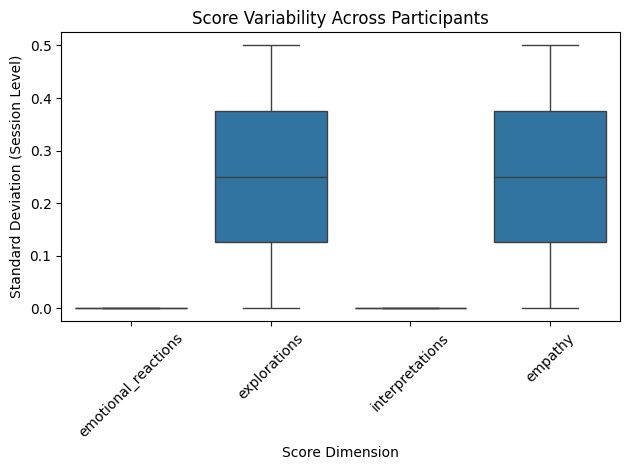

In [35]:
dimensions_raw = ["emotional_reactions", "explorations", "interpretations", "empathy"]
variability_df = pivot_df.groupby(["round", "participant"])[dimensions_raw].std().reset_index()


import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=variability_df.melt(id_vars=["round", "participant"]),
            x="variable", y="value")
plt.title("Score Variability Across Participants")
plt.ylabel("Standard Deviation (Session Level)")
plt.xlabel("Score Dimension")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [37]:
round_summary = agg_df.groupby("round")[dimensions].mean().reset_index()
round_summary 

,round,avg_emotional_reactions,avg_explorations,avg_interpretations,avg_empathy
0,round_1,1.0,1.977273,1.0,1.386364
1,round_2,1.0,2.000000,1.0,1.333333
2,round_3,1.0,2.000000,1.0,1.083333


In [15]:
agg_df.to_csv("aggregated_empathy_scores.csv", index=False)
